<a href="https://colab.research.google.com/github/Steve-YJ/Colab_Exercise/blob/master/%5BGraduate%5D_(feature_extraction)_03_ResNet_152_FeatureExtraction_from_pretrained_finetune_ResNet_152.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README.ME
* From <code> Nope</code>
* Add CNN-based Clasifier...!!
* LEGO~


✅ Check Point<br>
> 1. Malimg Classification using ResNet-152
> 2. Build ResNet-152 Feature Extractor
> 3. 1st. fine-tuned and train it
> 4. 2nd. Extract Features from fine-tuned ResNet-152
> 5. 3rd. Apply Softmax / Apply SVM (Comparison)
<br>

✅ Refactoring<br>
* 코드 정리좀 하자....!


🙋‍♂️ 진행사항 우선 Softmax를 적용해본다. 다음으로 SVM!
* 패기는 좋았지만... 전처리가 정말 쉽지 않다(-20.11.18.wed. pm 5:40-)
* 우여곡절 끝에 Feature를 추출할 수 있게 되었다! 
    * Function으로 만들고 전체 데이터 셋에 대해 Feature를 추출해보자


<code>::start:: 20.11.18. Wed pm 1:00 ~ </code><br>
<code>::Continue:: ~</code><br>
<code>::Add:</code><br>

* Need to save parameters -> Best Ressut
    * Reference: <a ref="https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html">PyTorch_Doc_ Transfer Learning</a>

In [1]:
"""
Can Do so many things... like,

1) Just Train CNN to our 3-channel Data
2) User pre-trained ResNet-VAE Encoder to Classifiy Malware Families
3) Extend Our Research to more...!

++++++++++++++++++++++  Up Date  +++++++++++++++++++++++++++++
4) Train many model as possible
5) Save Model's dict to post Exp
6) In Post Exp, we'll ensemble features and Build Ensemble model

"""

"\nCan Do so many things... like,\n\n1) Just Train CNN to our 3-channel Data\n2) User pre-trained ResNet-VAE Encoder to Classifiy Malware Families\n3) Extend Our Research to more...!\n\n++++++++++++++++++++++  Up Date  +++++++++++++++++++++++++++++\n4) Train many model as possible\n5) Save Model's dict to post Exp\n6) In Post Exp, we'll ensemble features and Build Ensemble model\n\n"

---
< Questions ><br>
Q1. Do you have Key-Papers?
<br>Image-based malware classification using ensemble of CNN architectures (IMCEC)</br>
https://www.sciencedirect.com/science/article/pii/S016740482030033X


---

*  Reference: 
    * <a ref = "https://pytorch.org/docs/stable/torchvision/models.html#wide-resnet">Pytorch pre-trained model</a>
    * <a ref = "https://www.programcreek.com/python/example/108010/torchvision.models.resnet152">How to implemnt transfer learning</a>
    * <a ref="https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html">Transfer Learning Tutorial, Save Best Model</a>

## Mount Drive

In [2]:
# Mount drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%cd drive/My\ Drive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master
# ! ls

/content/drive/My Drive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master


## 01. Import Library

In [5]:
from PIL import Image
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

# save single numpy array
from tempfile import TemporaryFile
from sklearn.manifold import TSNE

import torch
import torch.utils.data  # torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

import torchvision 
from torchvision import datasets, transforms
from torchvision.utils import save_image

# load modules
from torchvision import models
from modules import *

## 02. Data Preparation

* Make Custom Dataset
* Make Custom DataLoader
* 📌 edit Train_Val_Test Split
    * From <code>Train_Test Split</code> => <code>Train_Val_Test Split</code> 

### 📍 < Notice ><br>
* ResNet-VAE 모델을 훈련시킬 때는 데이터셋을 train, test만 준비한다.(Validation set 없이!)<br>
이는 일반적인 VAE Model Tutorial의 학습방식을 따른다. <code>-20.09.08.Tue. pm3:00-</code>
---

데이터 전처리

In [6]:
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # make 3-channel
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  # Composes several transforms together.

# make custom dataset
trainset = torchvision.datasets.ImageFolder(root='../../../../InformationSecurity_Summer/malimg',
                                            transform=transforms)

In [7]:
classes = trainset.classes
classes

['Adialer.C',
 'Agent.FYI',
 'Allaple.A',
 'Allaple.L',
 'Alueron.gen!J',
 'Autorun.K',
 'C2LOP.P',
 'C2LOP.gen!g',
 'Dialplatform.B',
 'Dontovo.A',
 'Fakerean',
 'Instantaccess',
 'Lolyda.AA1',
 'Lolyda.AA2',
 'Lolyda.AA3',
 'Lolyda.AT',
 'Malex.gen!J',
 'Obfuscator.AD',
 'Rbot!gen',
 'Skintrim.N',
 'Swizzor.gen!E',
 'Swizzor.gen!I',
 'VB.AT',
 'Wintrim.BX',
 'Yuner.A']

Split Train Data to Train, Test dataset

In [8]:
full_dataset = trainset

train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

print('print train_size, val_size, test_size: ', train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])  # Randomly split a dataset into non-overlapping new datasets of given lengths. Optionally fix the generator for reproducible results, e.g.:
print('print train_dataset, val_dataset, test_dataset: ', len(train_dataset), len(val_dataset), len(test_dataset))

print train_size, val_size, test_size:  7471 933 935
print train_dataset, val_dataset, test_dataset:  7471 933 935


In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=16,  # 16 to args.batch_size
                                           shuffle=True,
                                           pin_memory=True)
valid_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           pin_memory=True)  # (i.e., setting pin_memory=True)
                                                             #  which enables fast data transfer to CUDA-enabled GPUs
test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           pin_memory=True) 


# z_loader for feature extraction
z_loader = torch.utils.data.DataLoader(trainset,
                                  batch_size=32,
                                  shuffle=True,
                                  pin_memory=True)

3-channel Image를 출력하기 위해 print_loader라는 오브젝트도 하나 만들어보자

In [10]:
# For 3-channel Image print
print_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=4,
                                           shuffle=True,
                                           pin_memory=True)

3-channel Image 출

In [11]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()

    plt.imshow(np.transpose(np_img, (1, 2, 0)))  # Convert (C, W, H) to (W, H, C)

    print(np_img.shape)  # np_img shape
    print((np.transpose(np_img, (1, 2, 0))).shape)  # transposed shape 

In [12]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

tensor([24,  1,  2,  2, 24,  2,  2, 10,  3, 15, 19, 12,  2,  3, 22, 24])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 224, 224])
(3, 906, 906)
(906, 906, 3)
torch.Size([16, 3, 224, 224])
torch.Size([3, 454, 1810])
Yuner.A Agent.FYI Allaple.A Allaple.A Yuner.A Allaple.A Allaple.A Fakerean Allaple.L Lolyda.AT Skintrim.N Lolyda.AA1 Allaple.A Allaple.L VB.AT Yuner.A 


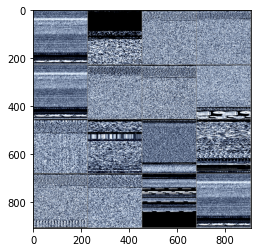

In [13]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(16)))

## 03. Model Architecture
* <code>pre-trained ResNet-152</code>
* <code>Transfer Learning</code>
* <code>Fine-Tunning</code>

이번 구현의 목적은 Feature Extractor이다<br>
pre-trained model의 마지막 레이어만 학습해보도록 하자!(코드를 보면 이해가 쉬울 것이다)

In [80]:
# Reference: https://www.programcreek.com/python/example/108010/torchvision.models.resnet152

def get_pretrained_resnet(new_fc_dim=None):
    """
    Reference: https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html

    이제, 마지막 계층을 제외한 신경망의 모든 부분을 고정해야 합니다. 
    requires_grad == False 로 설정하여
    매개변수를 고정하여 backward() 중에 경사도가 계산되지 않도록 해야합니다
    """
    
    # load pretrained_resnet152
    resnet152 = models.resnet152(pretrained=True)
    
    
    # Set requires_grad == False
    for param in resnet152.parameters():
        param.requires_grad = False
    
    # 새로 생성된 모듈의 매개변수는 기본값으로 requires_grad = True가 된다
    num_ftrs = resnet152.fc.in_features   # in_feature is the number of inputs for your linear layer:
                                         

    if new_fc_dim is not None:  # 마지막 계층의 유닛 개수를 변경해준다.
                                # For Classification        
        resnet152.fc = nn.Linear(num_ftrs, new_fc_dim)

        # _init_fc(resnet152.fc)
    else:
        pass
        # resnet152.fc = lambda x:x

    return resnet152

Feature Extraction을 위해 사전에 학습한 모델의 파라미터를 불러온다<br>

* 최적의 모델의 파라미터를 불러온다
* 아래의 코드를 통해 확인할 수 있다

In [81]:
import pickle

# load data
# 학습된 모델의 결과값을 불러온다
save_model_path = './graduate_resnet152_feature_extractor/fine_tune/'

with open(save_model_path+'resnet152_fe_results', 'rb') as fr:
    results_dict = pickle.load(fr)

# get best model
best_model = max(results_dict['list_test_acc'])
results_dict['list_test_acc'].index(best_model)

70

In [82]:
results_dict['list_test_acc'][70]

98.07486631016043

70번 째 모델의 파라미터를 불러온다

### 3-1. Load Model's Best Parameters

In [83]:
pre_saved_model_path = './graduate_resnet152_feature_extractor/fine_tune'

def get_best_model(pre_saved_model_path, epoch):
    pre_saved_model_path = os.path.join(pre_saved_model_path, 'model_epoch{}.pth'.format(epoch))
    return pre_saved_model_path

In [84]:
get_best_model(pre_saved_model_path, 71)

'./graduate_resnet152_feature_extractor/fine_tune/model_epoch71.pth'

In [85]:
# set path of pre-trained model
pre_saved_model_path = './graduate_resnet152_feature_extractor/fine_tune'
pre_saved_model_path = get_best_model(pre_saved_model_path, 71)

# load pre-trained ResNet-152

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Create model
resnet152 = get_pretrained_resnet(25)
resnet152.load_state_dict(torch.load(pre_saved_model_path))
# resnet152_fe.eval()  # 오늘 한 건했던 model.eval()

### strip the lat layer
feature_extractor = torch.nn.Sequential(*list(resnet152.children())[:-1])
for p in resnet152.parameters():
    p.requires_grad = False

feature_extractor.to(device)  # tensor에 올리기

### check this works
x = torch.randn([3, 3, 224, 224])
x = x.to(device)
output = feature_extractor(x)

print(output.shape)
print(output.view(3, -1).shape)

torch.Size([3, 2048, 1, 1])
torch.Size([3, 2048])


### 3-2. Extract latent features
* extract latent features from z_loader

* 실험 결과가 좋지 않으면 <a ref='https://www.kaggle.com/gennadylaptev/feature-extraction-with-pytorch-pretrained-models'>Kaggle Kernel (Feature extraction with PyTorch pre-trained models)</a> 참고하기

In [87]:
latent_features = np.zeros(shape=(len(full_dataset), 2048))
labels = np.zeros(shape=(len(full_dataset)))

print(latent_features.shape, labels.shape)


for i, (data, _) in enumerate(z_loader):
    feature_extractor.eval()  # for inference, Evaluation switch on!

    with torch.no_grad():
        data = data.to(device)
        label = _.to(device)
        
        output = feature_extractor(data).view(len(data), -1)  # batch_size만큼 값 저장
        
        label = label.view(-1)

    # save latent_vector
    feature_vector = output.detach().cpu().clone().numpy()  # change tensor type data to cpu().numpy()
                                                        # latent_vector_size: (num_of_data, 256)  # num_of_data, num_of_dim
    # save label
    label = label.detach().cpu().clone().numpy()

    latent_features[i*len(data): (i+1) * len(data)] = feature_vector
    labels[i*len(data): (i+1) * len(data)] = label
    print(i, '번째')


(9339, 2048) (9339,)
0 번째
1 번째
2 번째
3 번째
4 번째
5 번째
6 번째
7 번째
8 번째
9 번째
10 번째
11 번째
12 번째
13 번째
14 번째
15 번째
16 번째
17 번째
18 번째
19 번째
20 번째
21 번째
22 번째
23 번째
24 번째
25 번째
26 번째
27 번째
28 번째
29 번째
30 번째
31 번째
32 번째
33 번째
34 번째
35 번째
36 번째
37 번째
38 번째
39 번째
40 번째
41 번째
42 번째
43 번째
44 번째
45 번째
46 번째
47 번째
48 번째
49 번째
50 번째
51 번째
52 번째
53 번째
54 번째
55 번째
56 번째
57 번째
58 번째
59 번째
60 번째
61 번째
62 번째
63 번째
64 번째
65 번째
66 번째
67 번째
68 번째
69 번째
70 번째
71 번째
72 번째
73 번째
74 번째
75 번째
76 번째
77 번째
78 번째
79 번째
80 번째
81 번째
82 번째
83 번째
84 번째
85 번째
86 번째
87 번째
88 번째
89 번째
90 번째
91 번째
92 번째
93 번째
94 번째
95 번째
96 번째
97 번째
98 번째
99 번째
100 번째
101 번째
102 번째
103 번째
104 번째
105 번째
106 번째
107 번째
108 번째
109 번째
110 번째
111 번째
112 번째
113 번째
114 번째
115 번째
116 번째
117 번째
118 번째
119 번째
120 번째
121 번째
122 번째
123 번째
124 번째
125 번째
126 번째
127 번째
128 번째
129 번째
130 번째
131 번째
132 번째
133 번째
134 번째
135 번째
136 번째
137 번째
138 번째
139 번째
140 번째
141 번째
142 번째
143 번째
144 번째
145 번째
146 번째
147 번째
148 번째
149 번째
150 번째
151 번째
152 번째
153 번째
154 번째
155 

In [95]:
# latent_z = np.concatenate((latent_features, labels.reshape(-1, 1)), axis=1)
latent_z = np.concatenate((latent_features, labels.reshape(1, -1).T), axis=1)

pre_saved_model_path = './graduate_resnet152_feature_extractor/fine_tune'

latent_z_name = input("input_latnet_z_name: ")

with open((pre_saved_model_path+'/{}Epoch_z_vector_fine_tuned.npy'.format(71)), 'wb') as f:
        np.save(f, latent_z)  # 

input_latnet_z_name: good!


In [10]:
pre_saved_model_path = './graduate_resnet152_feature_extractor/fine_tune'

with open((pre_saved_model_path+'/{}Epoch_z_vector_fine_tuned.npy'.format(71)), 'rb') as f:
    latent_vectors = np.load(f)  # 

In [97]:
latent_vectors.shape

(9339, 2049)

EREKA!<br>
오늘 하루 삽질한 것에 대한 보상을 받는구나 ㅠㅠ -20.11.18.wed pm 9:30-

## 3-3. representation learning
* PCA
* SVM one-vs-all

PCA가 안되서 T-SNE각
* 다시 PCA...
    * from sklearn.decomposition import PCA

* reference: <a rer='https://teddylee777.github.io/scikit-learn/PCA%EB%A5%BC-%ED%99%9C%EC%9A%A9%ED%95%9C-%EC%B0%A8%EC%9B%90%EC%B6%95%EC%86%8C'>Apply PCA to latent features</a> 

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
result = pca.fit_transform(latent_vectors[:, :-1])

result = pd.DataFrame(result, columns=["x", "y"])

In [12]:
target_name = ['Adialer.C',
 'Agent.FYI',
 'Allaple.A',
 'Allaple.L',
 'Alueron.gen!J',
 'Autorun.K',
 'C2LOP.P',
 'C2LOP.gen!g',
 'Dialplatform.B',
 'Dontovo.A',
 'Fakerean',
 'Instantaccess',
 'Lolyda.AA1',
 'Lolyda.AA2',
 'Lolyda.AA3',
 'Lolyda.AT',
 'Malex.gen!J',
 'Obfuscator.AD',
 'Rbot!gen',
 'Skintrim.N',
 'Swizzor.gen!E',
 'Swizzor.gen!I',
 'VB.AT',
 'Wintrim.BX',
 'Yuner.A']

target_name = {idx:target for idx, target in enumerate(target_name)}
target_name

{0: 'Adialer.C',
 1: 'Agent.FYI',
 2: 'Allaple.A',
 3: 'Allaple.L',
 4: 'Alueron.gen!J',
 5: 'Autorun.K',
 6: 'C2LOP.P',
 7: 'C2LOP.gen!g',
 8: 'Dialplatform.B',
 9: 'Dontovo.A',
 10: 'Fakerean',
 11: 'Instantaccess',
 12: 'Lolyda.AA1',
 13: 'Lolyda.AA2',
 14: 'Lolyda.AA3',
 15: 'Lolyda.AT',
 16: 'Malex.gen!J',
 17: 'Obfuscator.AD',
 18: 'Rbot!gen',
 19: 'Skintrim.N',
 20: 'Swizzor.gen!E',
 21: 'Swizzor.gen!I',
 22: 'VB.AT',
 23: 'Wintrim.BX',
 24: 'Yuner.A'}

In [13]:
target = pd.DataFrame(latent_vectors[:, -1], columns=['type'])
target['type'] = target['type'].apply(lambda x: target_name[x])
merged = pd.concat([result, target], axis=1)
merged

,x,y,type
0,-0.716664,-2.995915,Lolyda.AA3
1,1.334905,-4.320938,Instantaccess
2,2.539305,1.156422,Dialplatform.B
3,2.803423,-0.816175,C2LOP.P
4,3.700201,-0.238466,VB.AT
...,...,...,...
9334,2.765847,1.099440,Adialer.C
9335,2.765847,1.099440,Adialer.C
9336,2.765847,1.099440,Adialer.C
9337,2.765847,1.099440,Adialer.C


In [14]:
merged = merged.sort_values(by=['type'])
merged

,x,y,type
9338,2.765847,1.099440,Adialer.C
3510,-0.281621,2.683570,Adialer.C
7475,-0.058268,3.017537,Adialer.C
1698,-0.349623,2.693410,Adialer.C
8523,-0.271660,2.659318,Adialer.C
...,...,...,...
6376,3.152926,-0.029817,Yuner.A
1916,3.152926,-0.029817,Yuner.A
3668,3.152926,-0.029817,Yuner.A
8133,3.152926,-0.029817,Yuner.A


#### 3.4.1 Plot PCA
* 2-dim PCA

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
findfont: Font family ['Nanum Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Nanum Gothic'] not found. Falling back to DejaVu Sans.


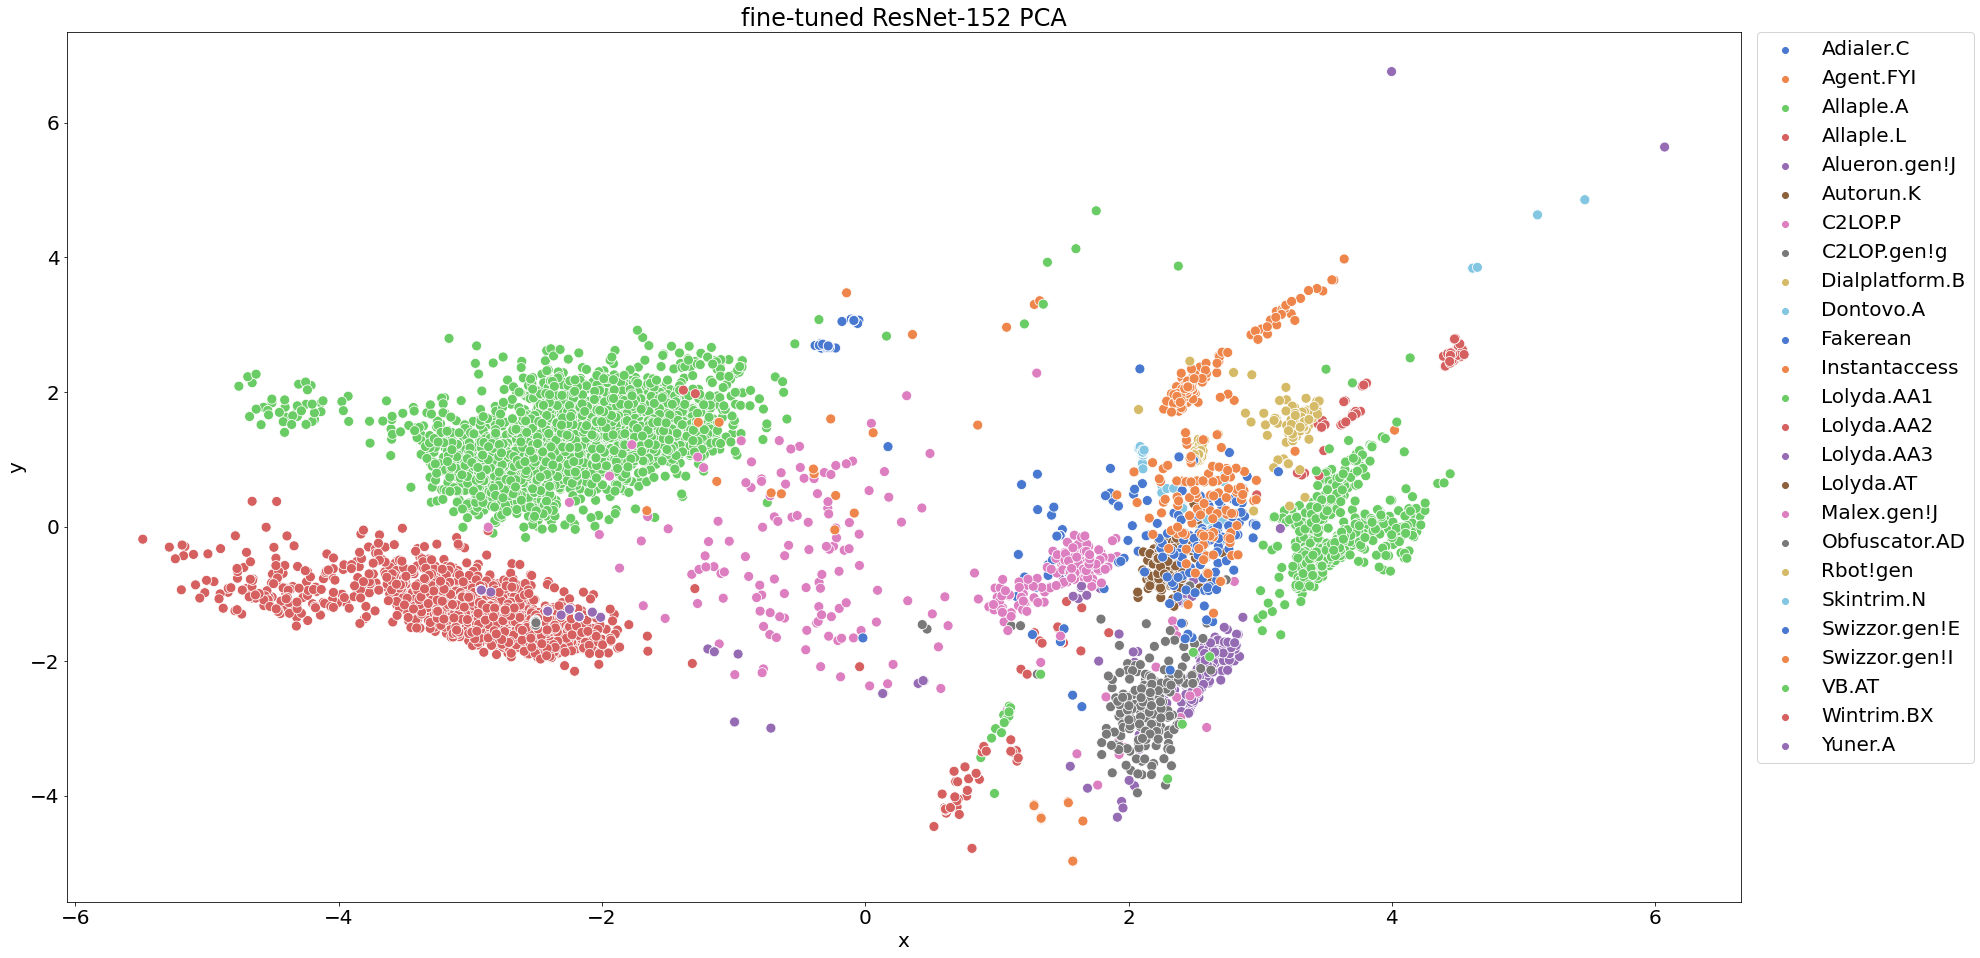

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns

%matplotlib inline

save_model_path = './graduate_resnet152_feature_extractor/fine_tune/'


# font 정의
mlp.rcParams['font.size'] = 20
mlp.rcParams['font.family'] = 'Nanum Gothic'

# 시각화
plt.figure(figsize=(30, 16))
sns.set_palette(sns.color_palette("muted"))

sns.scatterplot(merged['x'], 
                     merged['y'], 
                     hue=merged['type'], 
                     s=100,
                     palette=sns.color_palette('muted', n_colors=25),
                    )
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title('fine-tuned ResNet-152 PCA')
plt.savefig(save_model_path + './resnet152_finetune_PCA_Endddddd__201119 pm 11 test.png')

plt.show()

In [ ]:
from sklearn.datasets import load_wine 
from sklearn.multiclass import OneVsRestClassifier 
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, classification_report 
from sklearn.model_selection import train_test_split 
import warnings
import numpy as np
from sklearn.model_selection import train_test_split


X, y = merged.iloc[:, :-1], merged.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

'''
Reference: https://www.geeksforgeeks.org/one-vs-rest-strategy-for-multi-class-classification/
'''

# Creating the SVM model 
model = OneVsRestClassifier(SVC()) 
   
# Fitting the model with training data 
model.fit(X_train, y_train) 
   
# Making a prediction on the test set 
prediction = model.predict(X_test) 
   
# Evaluating the model 
print(f"Test Set Accuracy : {accuracy_score(y_test, prediction) * 100} %\n\n") 
print(f"Classification Report : \n\n{classification_report(y_test, prediction)}")

## 03. Model Architecture


```
Fine-Tuned ResNet-152 말고 오리지널 ResNet-152 Feature Extractor를 사용해보자

* pre-trained ResNet-152 Feature Extractor
* Q. 왜 결과값이 같게 나오는걸까...?
* model의 state_dict이 로드되지 않아서 일까?
    * 결과 값도 같네...
```



In [17]:
from sklearn.datasets import load_wine 
from sklearn.multiclass import OneVsRestClassifier 
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, classification_report 
from sklearn.model_selection import train_test_split 
import warnings
import numpy as np
from sklearn.model_selection import train_test_split


X, y = merged.iloc[:, :-1], merged.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

'''
Reference: https://www.geeksforgeeks.org/one-vs-rest-strategy-for-multi-class-classification/
'''

# Creating the SVM model 
model = OneVsRestClassifier(SVC()) 
   
# Fitting the model with training data 
model.fit(X_train, y_train) 
   
# Making a prediction on the test set 
prediction = model.predict(X_test) 
   
# Evaluating the model 
print(f"Test Set Accuracy : {accuracy_score(y_test, prediction) * 100} %\n\n") 
print(f"Classification Report : \n\n{classification_report(y_test, prediction)}")

(7004, 2) (2335, 2) (7004,) (2335,)
Test Set Accuracy : 85.78158458244111 %


Classification Report : 

                precision    recall  f1-score   support

     Adialer.C       0.95      0.81      0.88        48
     Agent.FYI       0.83      1.00      0.91        29
     Allaple.A       0.99      1.00      0.99       732
     Allaple.L       0.88      0.98      0.93       375
 Alueron.gen!J       0.85      0.59      0.69        58
     Autorun.K       0.00      0.00      0.00        21
       C2LOP.P       0.71      0.67      0.69        33
   C2LOP.gen!g       0.62      0.90      0.73        49
Dialplatform.B       0.67      1.00      0.80        52
     Dontovo.A       0.98      1.00      0.99        45
      Fakerean       0.61      0.98      0.75        84
 Instantaccess       0.94      1.00      0.97       116
    Lolyda.AA1       0.00      0.00      0.00        46
    Lolyda.AA2       0.94      0.94      0.94        48
    Lolyda.AA3       0.83      0.32      0.47        31

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PCA적용 전에는 결과가 어떨까?
* 20.11.19.Thur. pm 11:00
* 85% 이상일까?
* 2048 feature 사용하기

In [18]:
from sklearn.datasets import load_wine 
from sklearn.multiclass import OneVsRestClassifier 
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, classification_report 
from sklearn.model_selection import train_test_split 
import warnings
import numpy as np
from sklearn.model_selection import train_test_split


X, y = latent_vectors[:, :-1], latent_vectors[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

'''
Reference: https://www.geeksforgeeks.org/one-vs-rest-strategy-for-multi-class-classification/
'''

# Creating the SVM model 
model = OneVsRestClassifier(SVC()) 
   
# Fitting the model with training data 
model.fit(X_train, y_train) 
   
# Making a prediction on the test set 
prediction = model.predict(X_test) 
   
# Evaluating the model 
print(f"Test Set Accuracy : {accuracy_score(y_test, prediction) * 100} %\n\n") 
print(f"Classification Report : \n\n{classification_report(y_test, prediction)}")

(7004, 2048) (2335, 2048) (7004,) (2335,)
Test Set Accuracy : 97.98715203426124 %


Classification Report : 

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        40
         1.0       1.00      1.00      1.00        28
         2.0       1.00      1.00      1.00       742
         3.0       1.00      1.00      1.00       411
         4.0       1.00      1.00      1.00        43
         5.0       0.00      0.00      0.00        27
         6.0       0.92      0.97      0.94        35
         7.0       0.98      0.96      0.97        52
         8.0       0.98      1.00      0.99        43
         9.0       1.00      1.00      1.00        34
        10.0       1.00      1.00      1.00        84
        11.0       1.00      1.00      1.00        96
        12.0       0.98      1.00      0.99        59
        13.0       1.00      0.98      0.99        53
        14.0       1.00      1.00      1.00        30
        15.0       1.00  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Feature Extraction

In [112]:
# make empty vectors
latent_features = np.zeros(shape=(len(full_dataset), 2048))
labels = np.zeros(shape=(len(full_dataset)))

print(latent_features.shape, labels.shape)


for i, (data, _) in enumerate(z_loader):
    feature_extractor.eval()

    with torch.no_grad():
        data = data.to(device)
        label = _.to(device)
        output = feature_extractor(data).view(len(data), -1)  # batch_size만큼 값 저장
        label = label.view(-1)

    # save latent_vector
    feature_vector = output.detach().cpu().clone().numpy()  # change tensor type data to cpu().numpy()
                                                        # latent_vector_size: (num_of_data, 256)  # num_of_data, num_of_dim
    # save label
    label = label.detach().cpu().clone().numpy()

    latent_features[i*len(data): (i+1) * len(data)] = feature_vector
    labels[i*len(data): (i+1) * len(data)] = label
    print(i, '번째')


(9339, 2048) (9339,)
0 번째
1 번째
2 번째
3 번째
4 번째
5 번째
6 번째
7 번째
8 번째
9 번째
10 번째
11 번째
12 번째
13 번째
14 번째
15 번째
16 번째
17 번째
18 번째
19 번째
20 번째
21 번째
22 번째
23 번째
24 번째
25 번째
26 번째
27 번째
28 번째
29 번째
30 번째
31 번째
32 번째
33 번째
34 번째
35 번째
36 번째
37 번째
38 번째
39 번째
40 번째
41 번째
42 번째
43 번째
44 번째
45 번째
46 번째
47 번째
48 번째
49 번째
50 번째
51 번째
52 번째
53 번째
54 번째
55 번째
56 번째
57 번째
58 번째
59 번째
60 번째
61 번째
62 번째
63 번째
64 번째
65 번째
66 번째
67 번째
68 번째
69 번째
70 번째
71 번째
72 번째
73 번째
74 번째
75 번째
76 번째
77 번째
78 번째
79 번째
80 번째
81 번째
82 번째
83 번째
84 번째
85 번째
86 번째
87 번째
88 번째
89 번째
90 번째
91 번째
92 번째
93 번째
94 번째
95 번째
96 번째
97 번째
98 번째
99 번째
100 번째
101 번째
102 번째
103 번째
104 번째
105 번째
106 번째
107 번째
108 번째
109 번째
110 번째
111 번째
112 번째
113 번째
114 번째
115 번째
116 번째
117 번째
118 번째
119 번째
120 번째
121 번째
122 번째
123 번째
124 번째
125 번째
126 번째
127 번째
128 번째
129 번째
130 번째
131 번째
132 번째
133 번째
134 번째
135 번째
136 번째
137 번째
138 번째
139 번째
140 번째
141 번째
142 번째
143 번째
144 번째
145 번째
146 번째
147 번째
148 번째
149 번째
150 번째
151 번째
152 번째
153 번째
154 번째
155 

print latent vector and label

In [113]:
print(latent_features[:5], labels[:5])
print(latent_features.shape, labels.shape)

[[1.21709716 0.48405841 0.         ... 0.50343156 0.01131469 0.0083492 ]
 [1.02108967 0.30000418 0.03952765 ... 0.25142071 0.         0.02420505]
 [0.35572135 0.27118409 0.32617113 ... 0.92462999 0.11342616 0.01579456]
 [1.08462644 0.53635538 0.01187255 ... 0.67421329 0.         0.00349468]
 [0.91513711 0.57446778 0.01665466 ... 0.16722348 0.0565372  0.006878  ]] [ 2.  2. 14.  3.  2.]
(9339, 2048) (9339,)


In [120]:
print(latent_features.shape, labels.shape)

(9339, 2048) (9339,)


In [130]:
labels[:10]

array([ 2.,  2., 14.,  3.,  2.,  5., 24., 24., 24., 10.])

In [129]:
labels.reshape(1, -1)[0][:10]

array([ 2.,  2., 14.,  3.,  2.,  5., 24., 24., 24., 10.])

In [131]:
latent_z = np.concatenate((latent_features, labels.reshape(1, -1).T), axis=1)
latent_z.shape

(9339, 2049)

Apply PCA

In [137]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
result = pca.fit_transform(latent_z[:, :-1])

result = pd.DataFrame(result, columns=["x", "y"])
result

,x,y
0,-1.164120,-4.400891
1,-5.095662,-2.552483
2,4.429916,6.170473
3,-2.882277,-2.870075
4,-5.744795,-0.466632
...,...,...
9334,-1.856931,9.500977
9335,-1.856931,9.500977
9336,-1.856931,9.500977
9337,-1.856931,9.500977


In [138]:
target_name = ['Adialer.C',
 'Agent.FYI',
 'Allaple.A',
 'Allaple.L',
 'Alueron.gen!J',
 'Autorun.K',
 'C2LOP.P',
 'C2LOP.gen!g',
 'Dialplatform.B',
 'Dontovo.A',
 'Fakerean',
 'Instantaccess',
 'Lolyda.AA1',
 'Lolyda.AA2',
 'Lolyda.AA3',
 'Lolyda.AT',
 'Malex.gen!J',
 'Obfuscator.AD',
 'Rbot!gen',
 'Skintrim.N',
 'Swizzor.gen!E',
 'Swizzor.gen!I',
 'VB.AT',
 'Wintrim.BX',
 'Yuner.A']

target_name = {idx:target for idx, target in enumerate(target_name)}
target_name

{0: 'Adialer.C',
 1: 'Agent.FYI',
 2: 'Allaple.A',
 3: 'Allaple.L',
 4: 'Alueron.gen!J',
 5: 'Autorun.K',
 6: 'C2LOP.P',
 7: 'C2LOP.gen!g',
 8: 'Dialplatform.B',
 9: 'Dontovo.A',
 10: 'Fakerean',
 11: 'Instantaccess',
 12: 'Lolyda.AA1',
 13: 'Lolyda.AA2',
 14: 'Lolyda.AA3',
 15: 'Lolyda.AT',
 16: 'Malex.gen!J',
 17: 'Obfuscator.AD',
 18: 'Rbot!gen',
 19: 'Skintrim.N',
 20: 'Swizzor.gen!E',
 21: 'Swizzor.gen!I',
 22: 'VB.AT',
 23: 'Wintrim.BX',
 24: 'Yuner.A'}

In [140]:
target = pd.DataFrame(latent_z[:,-1], columns=['type'])
target['type'] = target['type'].apply(lambda x: target_name[x])
merged = pd.concat([result, target], axis=1)
merged = merged.sort_values(by=['type'])
merged

,x,y,type
9338,-1.856931,9.500977,Adialer.C
8499,8.649892,-1.701317,Adialer.C
3134,6.855991,-1.133509,Adialer.C
320,7.647459,-1.712403,Adialer.C
3142,6.783208,-1.087609,Adialer.C
...,...,...,...
3168,10.657436,-4.183080,Yuner.A
8636,10.657436,-4.183080,Yuner.A
721,10.657436,-4.183080,Yuner.A
7368,10.657436,-4.183080,Yuner.A


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


saved!
you can check the result at ./graduate_resnet152_feature_extractor/fine_tune/


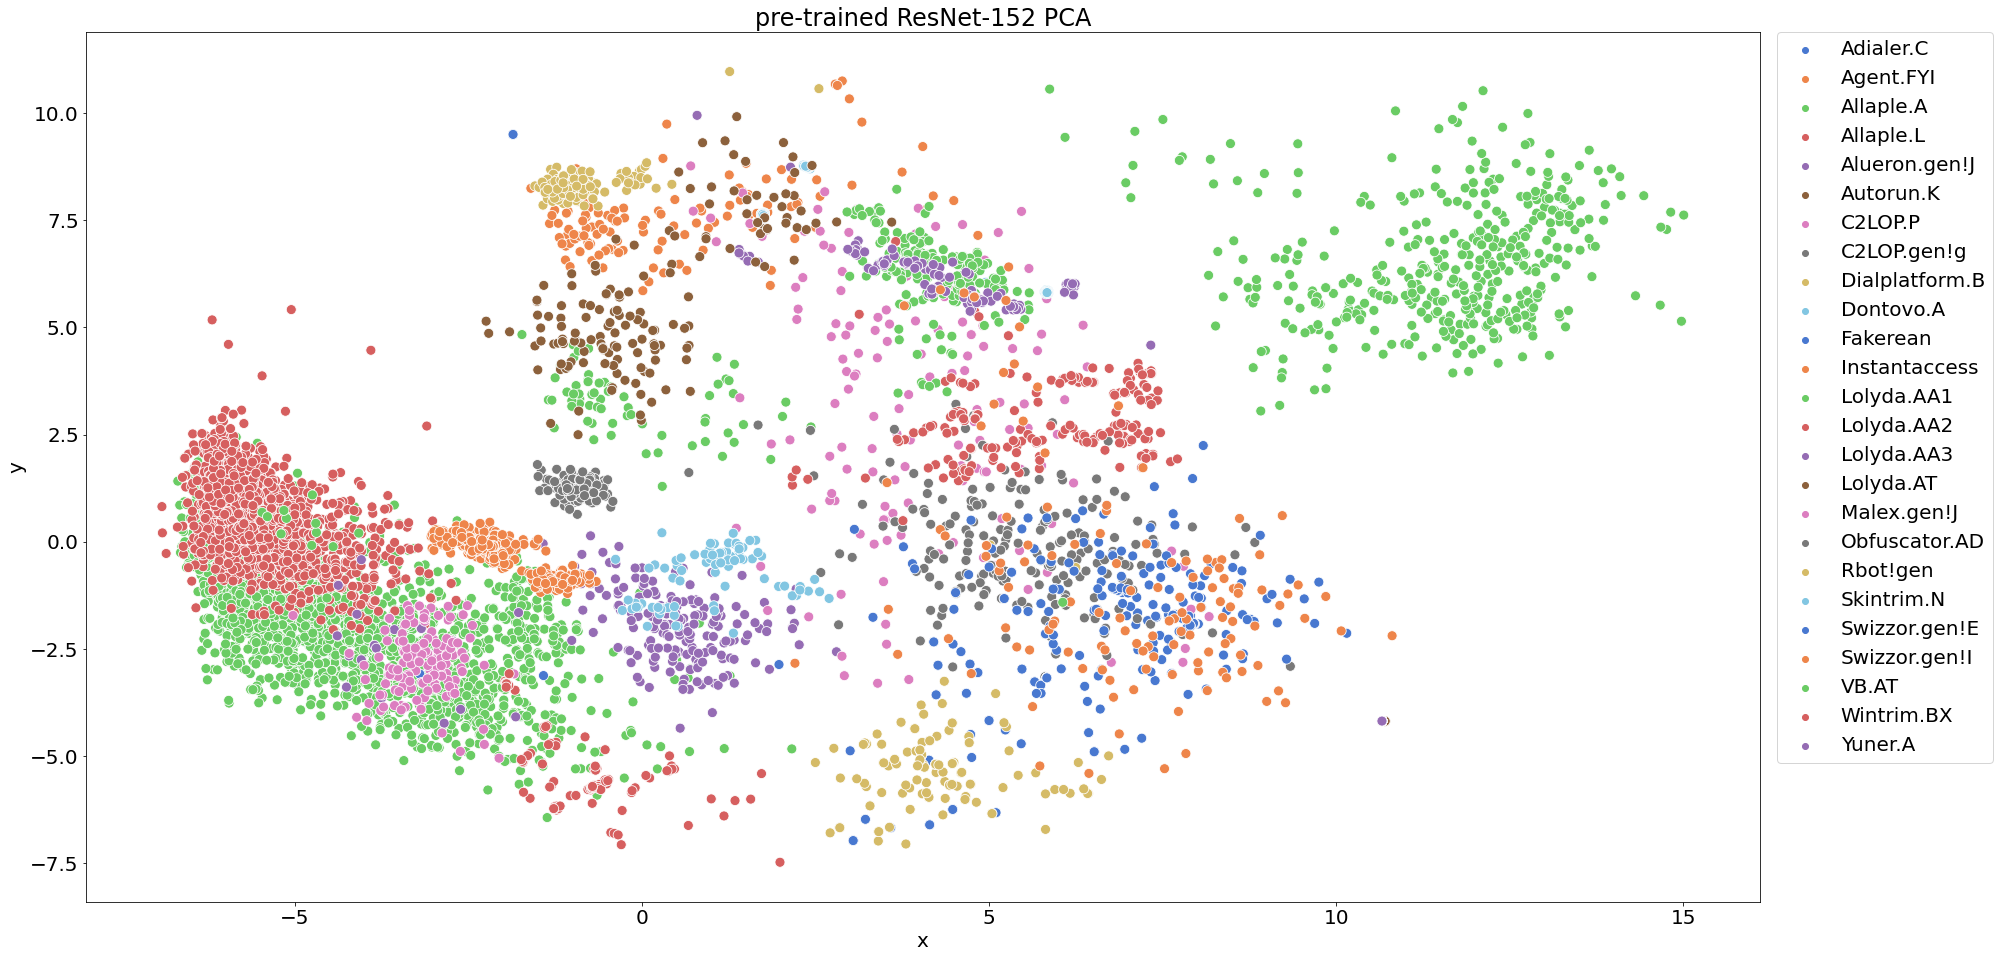

In [142]:
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns

%matplotlib inline

save_model_path = './graduate_resnet152_feature_extractor/fine_tune/'


# font 정의
mlp.rcParams['font.size'] = 20
mlp.rcParams['font.family'] = 'Nanum Gothic'

# 시각화

plt.figure(figsize=(30, 16))
sns.set_palette(sns.color_palette("muted"))

sns.scatterplot(merged['x'], 
                    merged['y'], 
                    hue=merged['type'], 
                    s=100,
                    palette=sns.color_palette('muted', n_colors=25),
                    )
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title('pre-trained ResNet-152 PCA')
plt.savefig(save_model_path + '/pre-trained ResNet-152 PCA find_answer 201119__edit')
print("saved!")
print("you can check the result at", save_model_path)
plt.show()

모델을 cuda 디바이스에 올려준다.

In [19]:
resnet152 = resnet152.to(device = ('cuda:0' if torch.cuda.is_available() else 'cpu'))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet152.parameters(), lr=0.001)  # Adam Optimizer를 사용하고 Learning rate는 0.001로한다.

In [ ]:
dataiter = iter(print_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels)

torch.Size([8, 3, 224, 224])
tensor([2, 2, 3, 5, 9, 3, 2, 0])


## Model Test해보기
* 모델 학습을 마치고 모델이 잘 학습됬는지 확인할 때 사용

In [51]:
# test output [ 0,  5,  9,  8, 12,  9,  0, 13]
with torch.no_grad():
    images = images.cuda()
    labels = labels.cuda()

    outputs = resnet152(images)
    print("outputs.shape: ", outputs.shape)
    print("Sum_outputs: ", outputs.sum())
    # print(outputs)


    _, predicted = torch.max(outputs.data, 1)  # return: values, indices
    print(_)
    print("print_predict: ", predicted)

print("print_answers: ", labels)


outputs.shape:  torch.Size([7, 25])
Sum_outputs:  tensor(-56799.8516, device='cuda:0')
tensor([320.7472, 469.0329, 484.6823, 302.2632, 711.0311, 653.0077, 297.3896],
       device='cuda:0')
print_predict:  tensor([ 8,  3,  3,  2, 14, 17, 20], device='cuda:0')
print_answers:  tensor([ 1,  3,  3,  2, 14, 17, 20], device='cuda:0')


* Change
    * 기존 함수 코드에서 실행 코드로 변경해보자...!

In [21]:
import argparse

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.net = resnet152
args.criterion = criterion
args.optim = optimizer

args.train_loader = train_loader
args.val_loader = valid_loader
args.test_loader = test_loader

# args.n_layer = 5
# args.in_dim = 3072
# args.out_dim = 10
# args.hid_dim = 100
# args.act = 'relu'

args.lr = 0.001  ## 우선 learning rate를 작게 가져가보도록 하자
args.mm = 0.9
args.epoch = 100


print(args)

Namespace(criterion=CrossEntropyLoss(), epoch=100, lr=0.001, mm=0.9, net=ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample):

<code>save_model_path</code>를 잘 정해주자! -20.11.16.Tue-

## 04. Train, Validate, Test and Experiment
* 함수화 필요 - 20.11.17.Tue-

In [27]:
"""
===== Update =====
* 이번에는 best_model_wts를 저장해줄거야!
** model_dict과 optimizer_dict을 저장!

*** list_ 값들도 저장해주면 나중에 결과 리포팅 하기에 좋지!
"""

## Reference: https://github.com/Steve-YJ/Exp-Standalone-DeepLearning/blob/master/%5BPractice%5D_Cifar10.ipynb
save_model_path = './graduate_resnet152_feature_extractor/fine_tune'

net = args.net  # resnet152
# criterion = criterion
# optimizer = optimizer

list_epoch = []
list_train_loss = []
list_val_loss = []

list_train_acc = []
list_val_acc = []
list_test_acc = []
list_acc_epoch = []

# save best_model_wts
# 잠시 보류
# best_model_wts = copy.deepcopy(net.state_dict())
# best_optim = copy.deepcopy(args.optim.state_dict())
# test_acc = 0.0

for epoch in range(args.epoch):  # loop over the dataset multiple itmes

    # ===== Train ===== #
    net.train()
    optimizer.zero_grad()

    running_loss = 0.0
    train_loss = 0.0

    correct = 0
    total = 0
    for i, data in enumerate(args.train_loader, 0):
        # get the inputs
        inputs, labels = data

        inputs = inputs.cuda()
        labels = labels.cuda()

        # forward + backward + optimize
        outputs = net(inputs)  # input 값의 shape이 맞는지 확인을 했는가? -20.09.16.Wed- am11:10...
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        train_loss += loss.item()
        if i % 100 == 99:  # print every 2000 mini-batches => print every 2 mini-batches
            print('[%d, %5d] loss: %.3f' %
                    (epoch+1, i+1, running_loss / 100))
            running_loss = 0.0

    train_loss = train_loss / len(args.train_loader)
    train_acc = 100 * correct / total
    # append list_values
    list_epoch.append(epoch)
    list_train_loss.append(train_loss)
    list_train_acc.append(train_acc)
    
    # save Pytorch models of best record
        # 10 Epoch마다 저장. 90 Epoch 이후로는 매 Epoch마다 결과 저장

    """
    학습 결과가 가장 좋은 모델의 결과값만 저장할수도 있겠죠?
    여전히 모르겠네...하하
    """
    if epoch % 10 == 0:   
        torch.save(net.state_dict(), os.path.join(save_model_path, 'model_epoch{}.pth'.format(epoch + 1)))  # save motion_encoder
        torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
        print("Epoch {} model saved!".format(epoch + 1))
    elif epoch >= 90: 
        torch.save(net.state_dict(), os.path.join(save_model_path, 'model_epoch{}.pth'.format(epoch + 1)))  # save motion_encoder
        torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
        print("Epoch {} model saved!".format(epoch + 1))

    # ===== Validation ===== #
    net.eval()
    optimizer.zero_grad()

    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in args.val_loader:
            images, labels = data
            # images = images.view(-1, 3072)

            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            '''
            What this code mean?
            '''
            _, predicted = torch.max(outputs.data, 1)  # return: values, indices
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(args.val_loader)
        val_acc = 100 * correct / total
        list_val_acc.append(val_acc)

        """
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(net.state_dict())
        """

    list_val_loss.append(val_loss)
    print('Epoch {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(epoch, train_loss, val_loss, val_acc))

    # ===== Evaluation ===== #
    net.eval()
    optimizer.zero_grad()

    correct = 0
    total = 0

    with torch.no_grad():
        for data in args.test_loader:
            images, labels = data
            # images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
        print('Epoch {}, Test Acc: {}'.format(epoch, test_acc))
    list_test_acc.append(test_acc)
    list_acc_epoch.append(epoch)



# save best result
# torch.save(best_model_wts, os.path.join(save_model_path, 'model_epoch{}.pth'.format(best)))      # save motion_encoder
# torch.save(bset_optim, os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(bset)))      # save optimizer

[1,   100] loss: 10.779
[1,   200] loss: 18.806
[1,   300] loss: 26.254
[1,   400] loss: 21.979
Epoch 1 model saved!
Epoch 0, Train Loss: 9253.398482203484, Val Loss: 24.8242656517837, Val Acc: 77.59914255091104
Epoch 0, Test Acc: 77.43315508021391
[2,   100] loss: 10.687
[2,   200] loss: 7.269
[2,   300] loss: 17.957
[2,   400] loss: 14.900
Epoch 1, Train Loss: 5936.656926292439, Val Loss: 34.32117035631406, Val Acc: 81.13612004287245
Epoch 1, Test Acc: 82.99465240641712
[3,   100] loss: 12.376
[3,   200] loss: 6.562
[3,   300] loss: 13.493
[3,   400] loss: 21.874
Epoch 2, Train Loss: 6202.569473777238, Val Loss: 13.636572112996006, Val Acc: 89.38906752411576
Epoch 2, Test Acc: 89.41176470588235
[4,   100] loss: 4.527
[4,   200] loss: 5.200
[4,   300] loss: 8.091
[4,   400] loss: 13.475
Epoch 3, Train Loss: 3901.15855620051, Val Loss: 17.37023960584301, Val Acc: 88.63879957127546
Epoch 3, Test Acc: 91.55080213903743
[5,   100] loss: 6.282
[5,   200] loss: 5.302
[5,   300] loss: 7.757


model train 결과 저장하기(list 값!)

In [43]:
 # save all train test results
import pickle
"""
pickle을 사용해서 dictionary형태로 저장한다.
"""

"""
list_epoch = []
list_train_loss = []
list_val_loss = []
list_test_acc = []
list_acc_epoch = []
"""
save_model_path = './graduate_resnet152_feature_extractor/'
results = {'list_epoch': list_epoch,
           'list_train_loss': list_train_loss,
           'list_val_loss': list_val_loss,
           'list_test_acc': list_test_acc ,
           'list_acc_epoch': list_acc_epoch}

with open(save_model_path+'resnet152_fe_results', 'wb') as fw:
    pickle.dump(results, fw)

In [44]:
# load data
with open(save_model_path+'resnet152_fe_results', 'rb') as fr:
    results_dict = pickle.load(fr)

# show data
print(results_dict)

{'list_epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 'list_train_loss': [9253.398482203484, 5936.656926292439, 6202.569473777238, 3901.15855620051, 3889.7348096868654, 7755.779782896389, 6836.588554910268, 3663.281950460412, 5119.446128432073, 6352.83220139988, 6364.913604362312, 3830.6236987959423, 2743.1807103787396, 2121.974829398113, 2919.1038342280854, 2075.2692918390167, 2694.256646335882, 3681.6777048163085, 3674.6780318654037, 2501.6171689668886, 3065.1025124451603, 3224.3485468200033, 4166.12950330948, 3231.29632937146, 3760.326443181537, 3292.600834898665, 3019.089124524049, 2318.329336153917, 2630.077243746958, 2017.43143461105

In [45]:
print(results_dict.keys())

dict_keys(['list_epoch', 'list_train_loss', 'list_val_loss', 'list_test_acc', 'list_acc_epoch'])


In [49]:
print(results_dict)

{'list_epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 'list_train_loss': [9253.398482203484, 5936.656926292439, 6202.569473777238, 3901.15855620051, 3889.7348096868654, 7755.779782896389, 6836.588554910268, 3663.281950460412, 5119.446128432073, 6352.83220139988, 6364.913604362312, 3830.6236987959423, 2743.1807103787396, 2121.974829398113, 2919.1038342280854, 2075.2692918390167, 2694.256646335882, 3681.6777048163085, 3674.6780318654037, 2501.6171689668886, 3065.1025124451603, 3224.3485468200033, 4166.12950330948, 3231.29632937146, 3760.326443181537, 3292.600834898665, 3019.089124524049, 2318.329336153917, 2630.077243746958, 2017.43143461105

## Manage Experiment Result
* 실험 결과를 어떻게 관리할 것인가
    * save_exp_result
    * load_exp_result

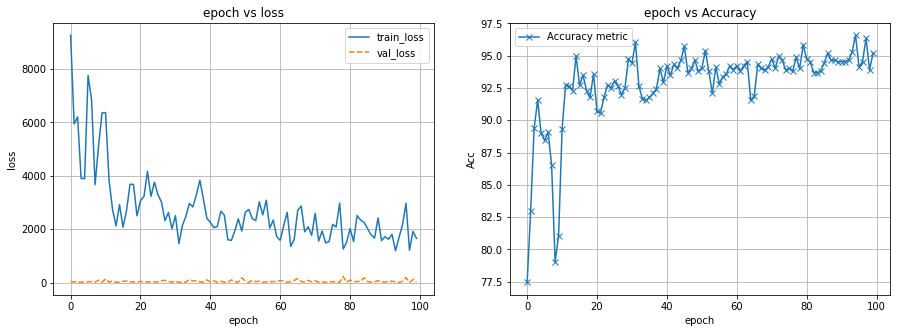

In [52]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(results_dict['list_epoch'], results_dict['list_train_loss'], label='train_loss')
ax1.plot(results_dict['list_epoch'], results_dict['list_val_loss'], '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(results_dict['list_acc_epoch'], results_dict['list_test_acc'], marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')


plt.savefig('./resnet152_FE.png')
plt.show()


결과 분석<br>
역시 중국의 논문은 걸러야 하나??<br>

* 결과 분석
    * Accuracy만 보면 높은데...
    * train, validation loss가 엉망이다?!
        * trainset에 비해 validationset이 쉽다면 이런 결과가 나온다고 한다...(신기하네...)
        * This may occur if the validation dataset has too few examples as compared to the training dataset
           

dropout layer가 추가된다면 가능하다고 한다.<br>
dropout layer의 기능은 일반화이다. 따라서 training loss는 약간 증가시키고 validation loss는 감소하여 반전 효과(inverted effect)를 줄 수 있다

## 실험 다시 해야한다!
* 1. train_loss 수정: ==> 전체 데이터 개수로 나눠줘야 한다...
* 2. train_acc, val_acc등 추가.

시간이 되면 Standalone-DL 참고해서 Fancy하게 코드를 수정하고 싶다...!

Notice<br>

1 Epoch 학습이 되면 이후 10 Epoch마다 model 및 optimizer 결과값 저장!


# 나는 잘 테니 너는 실험을 해놓아라

* ResNet-finetune
* fine-tunning을 해보자 - 20.11.18.wed am1:00-

In [17]:
# Reference: https://www.programcreek.com/python/example/108010/torchvision.models.resnet152

def get_pretrained_resnet(new_fc_dim=None):
    """
    Reference: https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html

    이제, 마지막 계층을 제외한 신경망의 모든 부분을 고정해야 합니다. 
    requires_grad == False 로 설정하여
    매개변수를 고정하여 backward() 중에 경사도가 계산되지 않도록 해야합니다
    """
    
    # load pretrained_resnet152
    resnet152 = models.resnet152(pretrained=True)
    
    """
    # Set requires_grad == False
    for param in resnet152.parameters():
        param.requires_grad = False
    """
    # 새로 생성된 모듈의 매개변수는 기본값으로 requires_grad = True가 된다
    num_ftrs = resnet152.fc.in_features   # in_feature is the number of inputs for your linear layer:
                                         

    if new_fc_dim is not None:  # 마지막 계층의 유닛 개수를 변경해준다.
                                # For Classification        
        resnet152.fc = nn.Linear(num_ftrs, new_fc_dim)

        # _init_fc(resnet152.fc)
    else:
        pass
        # resnet152.fc = lambda x:x

    return resnet152

In [18]:
resnet152 = get_pretrained_resnet(25)
resnet152

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
resnet152 = resnet152.to(device = ('cuda:0' if torch.cuda.is_available() else 'cpu'))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet152.parameters(), lr=0.001)  # Adam Optimizer를 사용하고 Learning rate는 0.001로한다.

In [20]:
import argparse

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.net = resnet152
args.criterion = criterion
args.optim = optimizer

args.train_loader = train_loader
args.val_loader = valid_loader
args.test_loader = test_loader

# args.n_layer = 5
# args.in_dim = 3072
# args.out_dim = 10
# args.hid_dim = 100
# args.act = 'relu'

args.lr = 0.001  ## 우선 learning rate를 작게 가져가보도록 하자
args.mm = 0.9
args.epoch = 100


print(args)

Namespace(criterion=CrossEntropyLoss(), epoch=100, lr=0.001, mm=0.9, net=ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample):

In [21]:
"""
===== Update =====
* 이번에는 best_model_wts를 저장해줄거야!
** model_dict과 optimizer_dict을 저장!

*** list_ 값들도 저장해주면 나중에 결과 리포팅 하기에 좋지!
"""

## Reference: https://github.com/Steve-YJ/Exp-Standalone-DeepLearning/blob/master/%5BPractice%5D_Cifar10.ipynb
save_model_path = './graduate_resnet152_feature_extractor/fine_tune'

net = args.net  # resnet152
# criterion = criterion
# optimizer = optimizer

list_epoch = []
list_train_loss = []
list_val_loss = []

list_train_acc = []
list_val_acc = []
list_test_acc = []
list_acc_epoch = []

# save best_model_wts
# 잠시 보류
# best_model_wts = copy.deepcopy(net.state_dict())
# best_optim = copy.deepcopy(args.optim.state_dict())
# test_acc = 0.0

for epoch in range(args.epoch):  # loop over the dataset multiple itmes

    # ===== Train ===== #
    net.train()
    optimizer.zero_grad()

    running_loss = 0.0
    train_loss = 0.0

    correct = 0
    total = 0
    for i, data in enumerate(args.train_loader, 0):
        # get the inputs
        inputs, labels = data

        inputs = inputs.cuda()
        labels = labels.cuda()

        # forward + backward + optimize
        outputs = net(inputs)  # input 값의 shape이 맞는지 확인을 했는가? -20.09.16.Wed- am11:10...
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:  # print every 2000 mini-batches => print every 2 mini-batches
            print('[%d, %5d] loss: %.3f' %
                    (epoch+1, i+1, running_loss / 100))
            running_loss = 0.0

    train_loss = train_loss / len(args.train_loader)
    train_acc = 100 * correct / total
    # append list_values
    list_epoch.append(epoch)
    list_train_loss.append(train_loss)
    list_train_acc.append(train_acc)
    
    # save Pytorch models of best record
        # 10 Epoch마다 저장. 90 Epoch 이후로는 매 Epoch마다 결과 저장

    """
    학습 결과가 가장 좋은 모델의 결과값만 저장할수도 있겠죠?
    여전히 모르겠네...하하
    """
    if epoch % 10 == 0:   
        torch.save(net.state_dict(), os.path.join(save_model_path, 'model_epoch{}.pth'.format(epoch + 1)))  # save motion_encoder
        torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
        print("Epoch {} model saved!".format(epoch+1))
    elif epoch >= 90: 
        torch.save(net.state_dict(), os.path.join(save_model_path, 'model_epoch{}.pth'.format(epoch + 1)))  # save motion_encoder
        torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
        print("Epoch {} model saved!".format(epoch+1))

    # ===== Validation ===== #
    net.eval()
    optimizer.zero_grad()

    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in args.val_loader:
            images, labels = data
            # images = images.view(-1, 3072)

            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            '''
            What this code mean?
            '''
            _, predicted = torch.max(outputs.data, 1)  # return: values, indices
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(args.val_loader)
        val_acc = 100 * correct / total
        list_val_acc.append(val_acc)

        """
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(net.state_dict())
        """

    list_val_loss.append(val_loss)
    print('Epoch {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(epoch+1, train_loss, val_loss, val_acc))

    # ===== Evaluation ===== #
    net.eval()
    optimizer.zero_grad()

    correct = 0
    total = 0

    with torch.no_grad():
        for data in args.test_loader:
            images, labels = data
            # images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
        print('Epoch {}, Test Acc: {}'.format(epoch+1, test_acc))
    list_test_acc.append(test_acc)
    list_acc_epoch.append(epoch)



# save best result
# torch.save(best_model_wts, os.path.join(save_model_path, 'model_epoch{}.pth'.format(best)))      # save motion_encoder
# torch.save(bset_optim, os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(bset)))      # save optimizer

[1,   100] loss: 3.287
[1,   200] loss: 3.162
[1,   300] loss: 2.476
[1,   400] loss: 1.989
Epoch 1 model saved!
Epoch 1, Train Loss: 2.6273565158343675, Val Loss: 1322.0737741761288, Val Acc: 5.466237942122186
Epoch 1, Test Acc: 4.919786096256685
[2,   100] loss: 1.850
[2,   200] loss: 2.537
[2,   300] loss: 2.089
[2,   400] loss: 1.619
Epoch 2, Train Loss: 1.957899499883999, Val Loss: 6.491186845100533, Val Acc: 62.37942122186495
Epoch 2, Test Acc: 61.92513368983957
[3,   100] loss: 1.464
[3,   200] loss: 1.526
[3,   300] loss: 1.774
[3,   400] loss: 1.502
Epoch 3, Train Loss: 1.5334233924969871, Val Loss: 1182.5851393170276, Val Acc: 41.69346195069668
Epoch 3, Test Acc: 38.18181818181818
[4,   100] loss: 1.268
[4,   200] loss: 1.296
[4,   300] loss: 1.823
[4,   400] loss: 4.354
Epoch 4, Train Loss: 2.2578203605380254, Val Loss: 1277.4993021609419, Val Acc: 26.473740621650588
Epoch 4, Test Acc: 25.56149732620321
[5,   100] loss: 2.321
[5,   200] loss: 2.143
[5,   300] loss: 2.188
[5,

In [22]:
 # save all train test results
import pickle
"""
pickle을 사용해서 dictionary형태로 저장한다.
"""

"""
list_epoch = []
list_train_loss = []
list_val_loss = []

list_train_acc = []
list_val_acc = []
list_test_acc = []
list_acc_epoch = []
"""

# pickle 파일로 저장
# set save_model_path
save_model_path = './graduate_resnet152_feature_extractor/fine_tune/'

results = {'list_epoch': list_epoch,
        'list_train_loss': list_train_loss,
        'list_val_loss': list_val_loss,
        'list_train_acc': list_train_acc,
        'list_val_acc': list_val_acc ,
        'list_test_acc': list_test_acc ,
        'list_acc_epoch': list_acc_epoch}

"""
with open(save_model_path+'resnet152_fe_results', 'wb') as fw:
    pickle.dump(results, fw)
print("Experiment results saved!")
"""

Experiment results saved!


In [20]:
import pickle


# load data

save_model_path = './graduate_resnet152_feature_extractor/fine_tune/'

with open(save_model_path+'resnet152_fe_results', 'rb') as fr:
    results_dict = pickle.load(fr)

# show data
print(results_dict)

{'list_epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 'list_train_loss': [2.6273565158343675, 1.957899499883999, 1.5334233924969871, 2.2578203605380254, 2.1160648798278876, 1.602273963886359, 1.4059495703821774, 1.046133484523863, 0.8812142485150434, 0.8404335064985001, 0.8144519786316526, 0.6754652656439285, 0.44988471261630475, 0.4475366615907666, 0.4637624931100923, 0.43442724649924025, 0.5973604036020455, 0.3018050645129073, 0.289087731820956, 0.25331965010768753, 0.22429284111574707, 0.22522389964346137, 0.18572761914972016, 0.1824111431000487, 0.2239622899689622, 0.19024760629375997, 0.15907417821679942, 0.1512755418881351, 0.1343836

In [50]:
print(results_dict.keys())
print(sorted(results_dict['list_test_acc']))

dict_keys(['list_epoch', 'list_train_loss', 'list_val_loss', 'list_train_acc', 'list_val_acc', 'list_test_acc', 'list_acc_epoch'])
[4.919786096256685, 25.56149732620321, 38.18181818181818, 38.39572192513369, 58.93048128342246, 60.0, 61.92513368983957, 62.88770053475936, 68.1283422459893, 71.22994652406418, 72.83422459893048, 75.93582887700535, 79.89304812834224, 80.64171122994652, 81.81818181818181, 88.1283422459893, 90.37433155080214, 90.4812834224599, 91.97860962566845, 92.62032085561498, 93.04812834224599, 93.68983957219251, 93.90374331550802, 94.11764705882354, 94.11764705882354, 94.22459893048128, 94.43850267379679, 94.54545454545455, 94.6524064171123, 94.8663101604278, 94.8663101604278, 95.50802139037434, 95.50802139037434, 95.50802139037434, 95.61497326203208, 95.61497326203208, 95.72192513368984, 95.72192513368984, 95.8288770053476, 95.8288770053476, 95.93582887700535, 95.93582887700535, 95.93582887700535, 95.93582887700535, 96.0427807486631, 96.0427807486631, 96.2566844919786,

In [71]:
print(results_dict['list_test_acc'][70])

98.07486631016043


In [57]:
print(results_dict['list_test_acc'].index(97.43315508021391)) 

64


In [38]:
import pickle


# load data
# 학습된 모델의 결과값을 불러온다
save_model_path = './graduate_resnet152_feature_extractor/fine_tune/'

with open(save_model_path+'resnet152_fe_results', 'rb') as fr:
    results_dict = pickle.load(fr)

# get best model
best_model = max(results_dict['list_test_acc'])
results_dict['list_test_acc'].index(best_model)

70

70

70번째 모델의 성능이 가장 좋다.

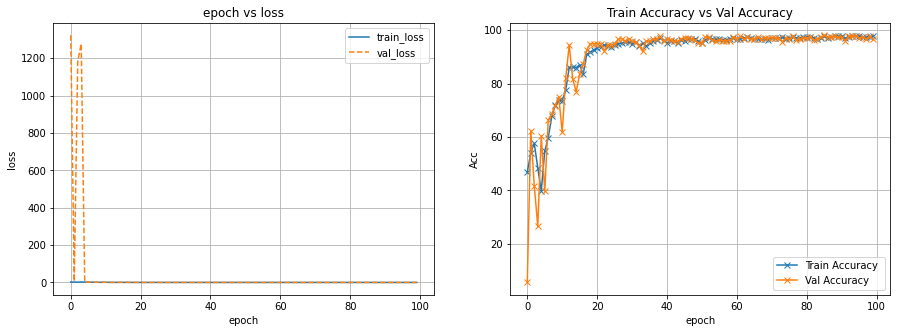

In [24]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(results_dict['list_epoch'], results_dict['list_train_loss'], label='train_loss')
ax1.plot(results_dict['list_epoch'], results_dict['list_val_loss'], '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(results_dict['list_acc_epoch'], results_dict['list_train_acc'], marker='x', label='Train Accuracy ')
ax2.plot(results_dict['list_acc_epoch'], results_dict['list_val_acc'], marker='x', label='Val Accuracy')

ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('Train Accuracy vs Val Accuracy')


plt.savefig(save_model_path + './resnet152_finetune.png')
plt.show()


---